# Learning curves

Construct learning curves and plot them.

In [1]:
import json
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from collections  import defaultdict
from hiphive      import StructureContainer
from trainstation import CrossValidationEstimator

In [2]:
# Read the file in JSON format to a dictionary
with open(f'setup_variables.json', 'r') as json_file:
    setup_variables = json.load(json_file)

In [11]:
linewidth = 2.0
markersize = 6
fontsize = 14
alpha = 0.5

columns = ['train_size', 'rmse_ave', 'rmse_std']

# parameters
fit_methods = ['lasso', 'ardr', 'least-squares']
train_sizes = np.linspace(100, 600, 15).astype(int)
n_splits = 5

# fit kwargs
fit_kwargs = defaultdict(dict)
fit_kwargs['lasso'] = dict(max_iter=5000)

### Run learning curves

In [12]:
# Read sc
sc = StructureContainer.read(setup_variables['path_to_structure_container'])
n_rows, n_cols = sc.data_shape

In [ ]:
learning_curves = dict()
for fit_method in fit_methods:
    records = []
    for train_size in train_sizes:
        train_fraction = train_size / n_rows
        test_fraction = 1.0 - train_fraction - 1e-10
        cve = CrossValidationEstimator(sc.get_fit_data(),
                                       fit_method=fit_method,
                                       validation_method='shuffle-split',
                                       train_size=train_fraction,
                                       test_size=test_fraction,
                                       n_splits=n_splits,
                                       **fit_kwargs[fit_method])
        cve.validate()
        row = dict(train_size=train_size,
                   rmse_ave=cve.rmse_validation,
                   rmse_std=cve.rmse_validation_splits.std())
        records.append(row)
    learning_curves[fit_method] = pd.DataFrame(records)

### Plot results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


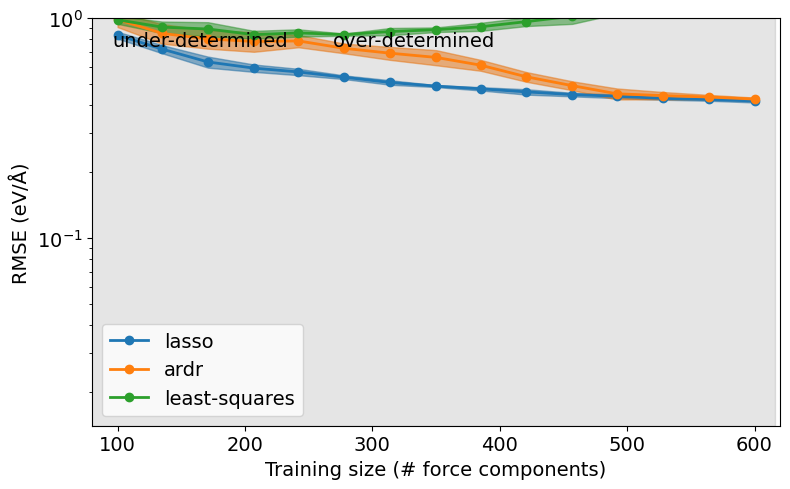

In [10]:
xlim = [min(train_sizes)-20, max(train_sizes)+20]
ylim = [0.014, 1.0]
colors = {fit_method: color for fit_method, color in zip(
    fit_methods, plt.rcParams['axes.prop_cycle'].by_key()['color'])}

fig = plt.figure(figsize=(8, 5))
ax = plt.gca()

for fit_method, df in learning_curves.items():
    col = colors[fit_method]
    ax.semilogy(df.train_size, df.rmse_ave, '-o', color=col, linewidth=linewidth, markersize=markersize,
                label='{}'.format(fit_method))
    ax.fill_between(df.train_size, df.rmse_ave - df.rmse_std,
                    df.rmse_ave + df.rmse_std, color=col, alpha=alpha)

ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('Training size (# force components)', fontsize=fontsize)
ax.set_ylabel('RMSE (eV/Å)', fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.legend(fontsize=fontsize)

ax.axvspan(0.0, n_cols, alpha=0.1, color='k')
ax.text(0.03, 0.93, 'under-determined', transform=ax.transAxes, fontsize=fontsize)
ax.text(0.35, 0.93, 'over-determined', transform=ax.transAxes, fontsize=fontsize)

fig.tight_layout()
plt.savefig('learning_curves.eps', dpi=50, bbox_inches='tight')